# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not rerun the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Quentin Rebjock"
student2 = "Augustin Prado"

**Seed value fixed because the hash function depends on the operating system :**

In [2]:
hash_value = 1993331184

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [26]:
print(keras.__version__)

2.1.5


In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline  

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
#np.random.seed(hash(student1 + student2) % 2**32)
np.random.seed(hash_value)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


Subset of class used:

In [9]:
# 1,0,9,3,4
subset_of_classes

array([1, 0, 9, 3, 4])

### Plotting

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [6]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [22]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

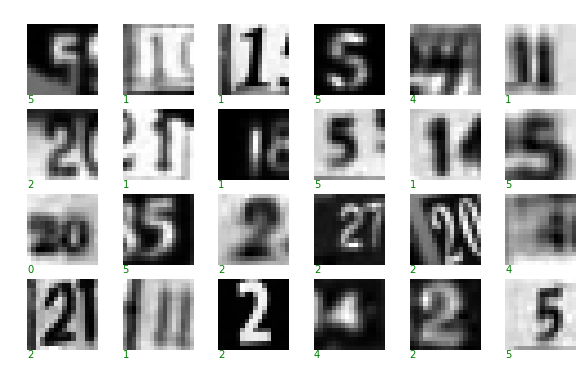

In [14]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [23]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Remark August:
- I don't see any increase after 30 epochs

In [28]:
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 100
input_shape = (16*16,)

model1 = Sequential()
model1.add(Dense(num_classes, activation='softmax', input_shape=input_shape))

model1.summary()

model1.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

history = model1.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________
Train on 43734 samples, validate on 15899 samples
Epoch 1/100
43734/43734 [==============================] - 1s 27us/step - loss: 1.5782 - acc: 0.2971 - val_loss: 1.5582 - val_acc: 0.3207
Epoch 2/100
43734/43734 [==============================] - 1s 22us/step - loss: 1.5608 - acc: 0.3157 - val_loss: 1.5502 - val_acc: 0.3260
Epoch 3/100
43734/43734 [==============================] - 1s 22us/step - loss: 1.5533 - acc: 0.3199 - val_loss: 1.5437 - val_acc: 0.3317
Epoch 4/100
43734/43734 [==============================] - 1s 22us/step - loss: 1.5475 - acc: 0.3242 - val_loss: 1.5393 - val_acc: 0.3357
Epoch 5/100
43734/43734 [==============================] - 1s 25us

KeyboardInterrupt: 

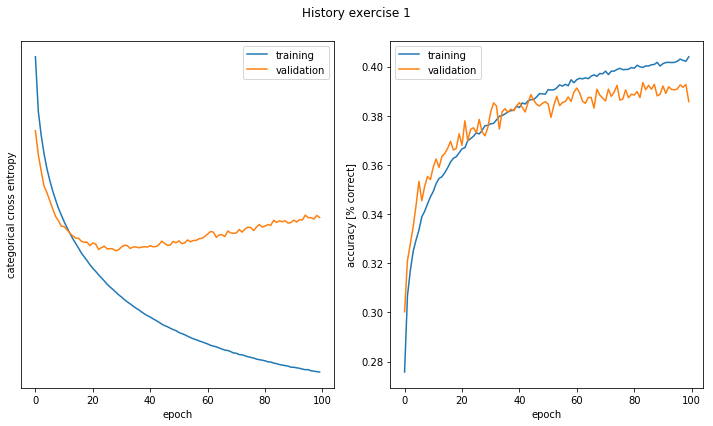

In [75]:
a = plot_history(history, 'History exercise 1')

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [30]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=input_shape))
model2.add(Dense(5, activation='softmax'))
model2.summary()

test_losses=[]
test_accs=[]

lrs = [0.0001, 0.001, 0.01, 0.1, 1 ,10]
for lr_ in lrs:
    
    model2.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=lr_),
                  metrics=['accuracy'])

    model2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=50,
                        verbose=0,
                        validation_data=(x_test, y_test))
    score = model2.evaluate(x_test, y_test, verbose=0)
    test_losses.append(score[0])
    test_accs.append(score[1])
    print('learning rate: ', lr_)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1], '\n')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 1.55451013562
Test accuracy: 0.309705012894
Test loss: 1.49411464556
Test accuracy: 0.347883514687
Test loss: 0.801904152906
Test accuracy: 0.753883892087
Test loss: 0.470566595543
Test accuracy: 0.873514057499
Test loss: 0.681402995625
Test accuracy: 0.820617648931
Test loss: 13.7012428189
Test accuracy: 0.149946537518


Plot with respect to different learning rates

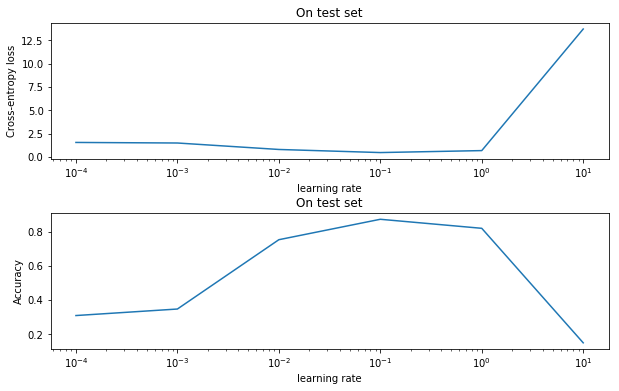

In [37]:
plt.subplots_adjust(hspace=0.4)
plt.subplot(2,1,1)
plt.semilogx(lrs, test_losses)
plt.title('On test set')
plt.ylabel('Cross-entropy loss')
plt.xlabel('learning rate')

plt.subplot(2,1,2)
plt.semilogx(lrs, test_accs)
plt.title('On test set')
plt.ylabel('Accuracy')
plt.xlabel('learning rate')
plt.show()

With Adam optimizer:

In [45]:
from keras.optimizers import Adam

In [54]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=input_shape))
model2.add(Dense(5, activation='softmax'))

optimizer = Adam()
model2.compile(loss='categorical_crossentropy',
                  optimizer = optimizer,
                  metrics=['accuracy'])

model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    verbose=2,
                    validation_data=(x_test, y_test))

Train on 43734 samples, validate on 15899 samples
Epoch 1/50
 - 2s - loss: 1.3533 - acc: 0.4652 - val_loss: 1.1129 - val_acc: 0.6548
Epoch 2/50
 - 2s - loss: 0.9395 - acc: 0.7079 - val_loss: 0.8634 - val_acc: 0.7414
Epoch 3/50
 - 2s - loss: 0.7614 - acc: 0.7771 - val_loss: 0.7726 - val_acc: 0.7646
Epoch 4/50
 - 2s - loss: 0.6788 - acc: 0.8010 - val_loss: 0.7303 - val_acc: 0.7823
Epoch 5/50
 - 2s - loss: 0.6283 - acc: 0.8161 - val_loss: 0.7016 - val_acc: 0.7931
Epoch 6/50
 - 2s - loss: 0.5962 - acc: 0.8261 - val_loss: 0.6656 - val_acc: 0.8017
Epoch 7/50
 - 1s - loss: 0.5713 - acc: 0.8306 - val_loss: 0.6445 - val_acc: 0.8106
Epoch 8/50
 - 2s - loss: 0.5501 - acc: 0.8373 - val_loss: 0.6381 - val_acc: 0.8128
Epoch 9/50
 - 2s - loss: 0.5342 - acc: 0.8404 - val_loss: 0.6475 - val_acc: 0.8052
Epoch 10/50
 - 2s - loss: 0.5189 - acc: 0.8452 - val_loss: 0.6078 - val_acc: 0.8217
Epoch 11/50
 - 1s - loss: 0.5040 - acc: 0.8505 - val_loss: 0.5873 - val_acc: 0.8293
Epoch 12/50
 - 2s - loss: 0.4915 - 

We achieve with Adam optimizer a better loss and accuracy, compared to the best result of the SGD optimizer.

- Loss: 0.43 (Adam) vs 0.47 (SGD)
- Accuracy: 0.89 (Adam) vs 0.87 (SGD)

In [55]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1], '\n')

Test loss: 0.436292751395
Test accuracy: 0.88760299391 



**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) 

B) 

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

[JE NE L AI PAS FAIS TOURNER ASSEZ LONGTEMPS, FAUDRAIT VOIR CE QUE CA FAIT 1000 epochs]

In [61]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=input_shape))
model2.add(Dense(5, activation='softmax'))

optimizer = Adam()
model2.compile(loss='categorical_crossentropy',
                  optimizer = optimizer,
                  metrics=['accuracy'])

history = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=200,
                    verbose=2,
                    validation_data=(x_test, y_test))

Train on 43734 samples, validate on 15899 samples
Epoch 1/200
 - 2s - loss: 1.3424 - acc: 0.4753 - val_loss: 1.0703 - val_acc: 0.6331
Epoch 2/200
 - 2s - loss: 0.9102 - acc: 0.7220 - val_loss: 0.8404 - val_acc: 0.7400
Epoch 3/200
 - 2s - loss: 0.7463 - acc: 0.7799 - val_loss: 0.7788 - val_acc: 0.7679
Epoch 4/200
 - 2s - loss: 0.6693 - acc: 0.8039 - val_loss: 0.7306 - val_acc: 0.7838
Epoch 5/200
 - 2s - loss: 0.6245 - acc: 0.8181 - val_loss: 0.7048 - val_acc: 0.7912
Epoch 6/200
 - 2s - loss: 0.5931 - acc: 0.8248 - val_loss: 0.6694 - val_acc: 0.7973
Epoch 7/200
 - 2s - loss: 0.5672 - acc: 0.8307 - val_loss: 0.6524 - val_acc: 0.8069
Epoch 8/200
 - 2s - loss: 0.5458 - acc: 0.8382 - val_loss: 0.6638 - val_acc: 0.8016
Epoch 9/200
 - 2s - loss: 0.5300 - acc: 0.8423 - val_loss: 0.6293 - val_acc: 0.8121
Epoch 10/200
 - 2s - loss: 0.5120 - acc: 0.8464 - val_loss: 0.6010 - val_acc: 0.8195
Epoch 11/200
 - 2s - loss: 0.4981 - acc: 0.8512 - val_loss: 0.6014 - val_acc: 0.8195
Epoch 12/200
 - 2s - los

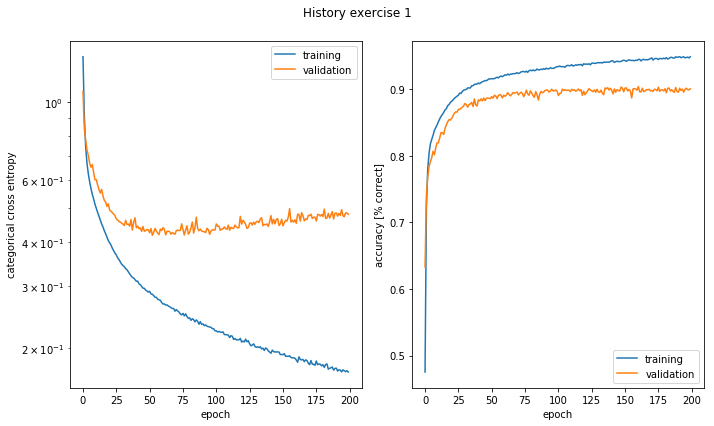

In [62]:
a = plot_history(history, 'History exercise 1')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**:

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [58]:
test_losses=[]
test_accs=[]
hidden = [5, 50, 100, 300, 500, 750, 1000]
for nb_neurons in hidden:
    models = Sequential()
    models.add(Dense(nb_neurons, activation='relu', input_shape=input_shape))
    models.add(Dense(5, activation='softmax'))
    optimizer = Adam()
    models.compile(loss='categorical_crossentropy',
                  optimizer = optimizer,
                  metrics=['accuracy'])

    models.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=70,
                    verbose=0,
                    validation_data=(x_test, y_test))
    score = models.evaluate(x_test, y_test, verbose=0)
    test_losses.append(score[0])
    test_accs.append(score[1])
    print('For ', nb_neurons, ' hidden neurons in the model:')
    print('Test loss:', score[0])
    print('Test accuracy:', score[1], '\n')

For  5  hidden neurons in the model:
Test loss: 1.047679099
Test accuracy: 0.63349896218 

For  50  hidden neurons in the model:
Test loss: 0.462429891394
Test accuracy: 0.884395245033 

For  100  hidden neurons in the model:
Test loss: 0.428409113059
Test accuracy: 0.898043902143 

For  300  hidden neurons in the model:
Test loss: 0.431052377295
Test accuracy: 0.904710988124 

For  500  hidden neurons in the model:
Test loss: 0.471142413157
Test accuracy: 0.900119504383 

For  750  hidden neurons in the model:
Test loss: 0.488392465982
Test accuracy: 0.90257248881 

For  1000  hidden neurons in the model:
Test loss: 0.4991705278
Test accuracy: 0.901000062908 



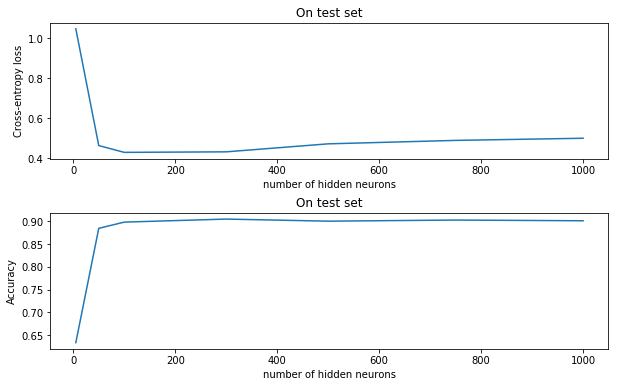

In [59]:
plt.subplots_adjust(hspace=0.4)
plt.subplot(2,1,1)
plt.plot(hidden, test_losses)
plt.title('On test set')
plt.ylabel('Cross-entropy loss')
plt.xlabel('number of hidden neurons')

plt.subplot(2,1,2)
plt.plot(hidden, test_accs)
plt.title('On test set')
plt.ylabel('Accuracy')
plt.xlabel('number of hidden neurons')
plt.show()

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution